In [12]:
!pip install tensorflow keras
!pip install shap

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [14]:
def load_and_preprocess_data(data):
    df = data.copy()

    # Definir categorías de "aprobar", "negar" e "Indeterminados"
    aprobar = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
    negar = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off']

    # Crear la variable objetivo (1 = incumplimiento, 0 = cumplimiento)
    df['default'] = df['loan_status'].apply(lambda x: 1 if x in negar else 0 if x in aprobar else np.nan)

    # Eliminar filas con estado "Indeterminado" (para evitar sesgo en el modelo)
    df = df.dropna(subset=['default'])

    # Seleccionar features relevantes
    features = ['annual_inc', 'dti', 'revol_bal', 'revol_util', 'open_acc',
                'total_acc', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec',
                'emp_length', 'home_ownership', 'purpose', 'addr_state','term']

    df = df[features + ['default']] # Only keep the features and target variable

    # Preprocesar "emp_length" (años de empleo)
    df['emp_length'] = df['emp_length'].fillna('0')
    df['emp_length'] = df['emp_length'].replace('10+ years', '10')
    df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)

    # Convertir variables categóricas en variables dummy
    categorical_features = ['home_ownership', 'purpose', 'addr_state', 'term']
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    print(categorical_features)


    # Separar X e y
    X = df.drop(columns=['default'])  # Eliminar variables innecesarias
    y = df['default']

    # Imputar valores faltantes en X solo para columnas numéricas
    numeric_cols = X.select_dtypes(include=np.number).columns
    X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())

    return X, y

In [15]:
def create_model(input_dim, architecture=[64, 32]):
    model = Sequential()
    # Primera capa
    model.add(Dense(architecture[0], activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))
    # Capas ocultas
    for units in architecture[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.3))
    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [17]:
# 3. Entrenar y evaluar modelo
def train_and_evaluate_model(X, y):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Escalar features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Crear y entrenar modelo
    model = create_model(X_train.shape[1])

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(
        X_train_scaled, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Predicciones
    y_pred_prob = model.predict(X_test_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Classification Report
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
    print(report)

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Gráficos de pérdida y precisión
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Curva de pérdida
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Curva de precisión
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Guardar el modelo y el scaler
    model.save("modelo_entrenado.keras")
    with open("scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)

    # Extraer métricas detalladas del classification_report como diccionario
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    print("\nMétricas detalladas por clase:")
    for class_name in ['0', '1']:
        print(f"\nClase {class_name}:")
        print(f"Precisión: {report_dict[class_name]['precision']:.4f}")
        print(f"Recall: {report_dict[class_name]['recall']:.4f}")
        print(f"F1-score: {report_dict[class_name]['f1-score']:.4f}")

    return model, scaler, X_test, y_test


<ipython-input-18-0c15c586fa70>:3: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loan.csv", on_bad_lines='skip')
<ipython-input-18-0c15c586fa70>:5: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loan.csv", on_bad_lines='skip')


['home_ownership', 'purpose', 'addr_state', 'term']
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5139/5139 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8051 - loss: 0.4904 - val_accuracy: 0.8159 - val_loss: 0.4495
Epoch 2/100
5139/5139 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8156 - loss: 0.4523 - val_accuracy: 0.8159 - val_loss: 0.4486
Epoch 3/100
5139/5139 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8164 - loss: 0.4485 - val_accuracy: 0.8159 - val_loss: 0.4469
Epoch 4/100
5139/5139 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.8139 - loss: 0.4510 - val_accuracy: 0.8156 - val_loss: 0.4458
Epoch 5/100
5139/5139 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8151 - loss: 0.4489 - val_accuracy: 0.8164 - val_loss: 0.4453
Epoch 6/100
5139/5139 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8168 - loss: 0.4451 - val_accuracy: 0.8161 - val_loss: 0.4457
Epoch 7/100
5139/5139 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.8160 - loss: 0.4449 - val_accuracy: 0.8164 - val_loss: 0.4451
Epoch 8/100
5139/5139 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8156 - loss: 0.445

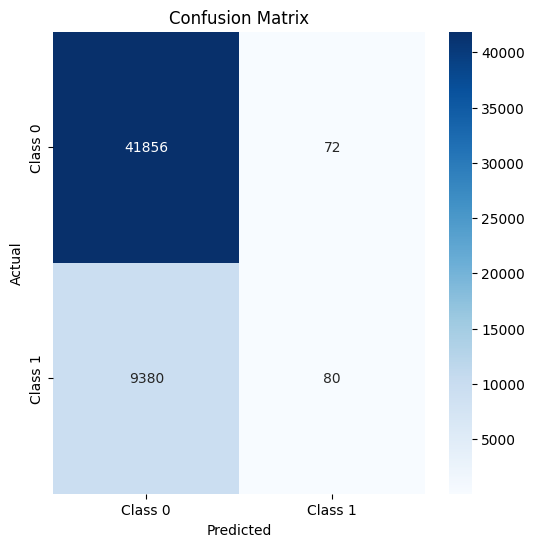

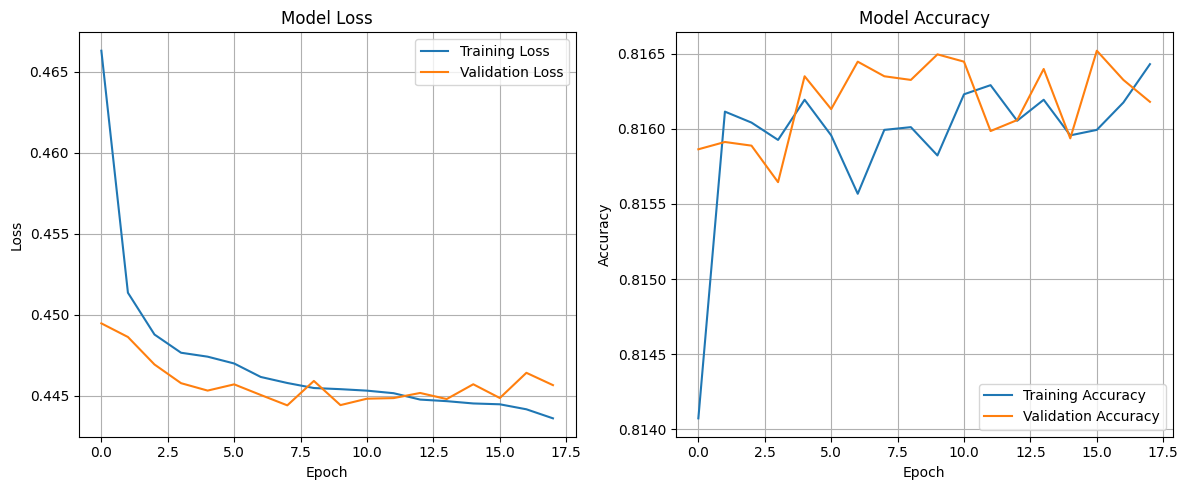


Métricas detalladas por clase:

Clase 0:


KeyError: '0'

In [18]:
if __name__ == "__main__":
    # Cargar datos
    df = pd.read_csv("loan.csv", on_bad_lines='skip')
    try:
        df = pd.read_csv("loan.csv", on_bad_lines='skip')
    except pd.errors.ParserError as e:
        print(f"Error reading CSV: {e}")
        # Option 1: Skip the problematic row and continue
        line_number = int(str(e).split('row ')[1].split(',')[0])
        df = pd.read_csv("loan.csv", skiprows=[line_number], on_bad_lines='skip')
        print(f"Skipped row {line_number} and continued loading.")

    # Preprocesar datos
    X, y = load_and_preprocess_data(df)

    # Entrenar y evaluar modelo
    model, scaler, X_test, y_test = train_and_evaluate_model(X, y)




Para las variables que hacen más riesgosa a una persona, el modelo analizará:

Monto del préstamo (loan_amnt)
Tasa de interés (int_rate)
Cuota mensual (installment)
Ingreso anual (annual_inc)
Ratio deuda/ingreso (dti)
Historial de morosidad (delinq_2yrs)
Consultas crediticias recientes (inq_last_6mths)
Cuentas abiertas (open_acc)
Registros públicos (pub_rec)
Balance revolvente (revol_bal)
Utilización de crédito revolvente (revol_util)
Total de cuentas (total_acc)
Tiempo de empleo (emp_length)